<a href="https://colab.research.google.com/github/christina3099/Plant-Health-Monitor/blob/main/Plant_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import tensorflow as tf

In [ ]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
zip_path = '/content/drive/MyDrive/archive (1).zip'
file_path = '/content/drive/MyDrive/plant_dataset'

In [ ]:
if not os.path.exists(file_path):
  os.makedirs(file_path)
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(file_path)
  print("Dataset extracted successfully")
else:
  print("Dataset already extracted at:", file_path)


Dataset extracted successfully


In [ ]:
IMG_SIZE =(256,256)
BATCH_SIZE = 32

train_dir = '/content/drive/MyDrive/plant_dataset/Train/Train'
val_dir = '/content/drive/MyDrive/plant_dataset/Validation/Validation'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "sparse",
    shuffle = True
)



Found 1322 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['Healthy', 'Powdery', 'Rust']

In [ ]:
val_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 10,
    horizontal_flip = True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size= IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "sparse"

)

Found 60 images belonging to 3 classes.


In [ ]:
test_dir ='/content/drive/MyDrive/plant_dataset/Test/Test'
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    horizontal_flip = True

)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "sparse"
)

Found 150 images belonging to 3 classes.


In [ ]:
import numpy as np

num_samples = train_generator.samples  # total images

# generator that yields single samples (not batches) and stops after all samples
def sample_generator():
    yielded = 0
    # train_generator is an infinite iterator; we stop after num_samples yielded items
    while yielded < num_samples:
        x_batch, y_batch = next(train_generator)
        # x_batch shape: (batch_size, H, W, C)
        for i in range(x_batch.shape[0]):
            if yielded >= num_samples:
                return
            # ensure types are TF-friendly
            img = x_batch[i].astype(np.float32)
            label = np.int32(y_batch[i])
            yielded += 1
            yield img, label

# create tf.data dataset from the python generator
output_types = (tf.float32, tf.int32)
output_shapes = (tf.TensorShape([IMG_SIZE[0], IMG_SIZE[1], 3]), tf.TensorShape([]))

ds = tf.data.Dataset.from_generator(sample_generator,
                                    output_types=output_types,
                                    output_shapes=output_shapes)

AUTOTUNE = tf.data.AUTOTUNE

# batch, cache and prefetch
ds = ds.batch(BATCH_SIZE)
ds = ds.cache()             # or ds.cache('/tmp/my_cache')
ds = ds.prefetch(AUTOTUNE)

# use ds for training
# model.fit(ds, epochs=..., steps_per_epoch=math.ceil(num_samples/BATCH_SIZE), ...)


In [ ]:
input_shape = (256,256,3)
n_classes = 3
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
ds = ds.repeat()

In [ ]:
history = model.fit(
    ds,
    steps_per_epoch = 47,
    batch_size= BATCH_SIZE,
    validation_data= val_generator,
    verbose= 1,
    epochs = 20,
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6039 - loss: 0.7624

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.6051 - loss: 0.7609 - val_accuracy: 0.7167 - val_loss: 0.6376
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7290 - loss: 0.6078 - val_accuracy: 0.8000 - val_loss: 0.4416
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8839 - loss: 0.3353 - val_accuracy: 0.8500 - val_loss: 0.4241
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9226 - loss: 0.2566 - val_accuracy: 0.9333 - val_loss: 0.2343
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9497 - loss: 0.1375 - val_accuracy: 0.9167 - val_loss: 0.2455
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9570 - loss: 0.1253 - val_accuracy: 0.9000 - val_loss: 0.3498
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9465 - loss: 0.1556 - val_accuracy: 0.8833 - val_loss: 0.3150
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9656 - loss: 0.1111 - val_accuracy: 0.9333 - val_loss: 0.

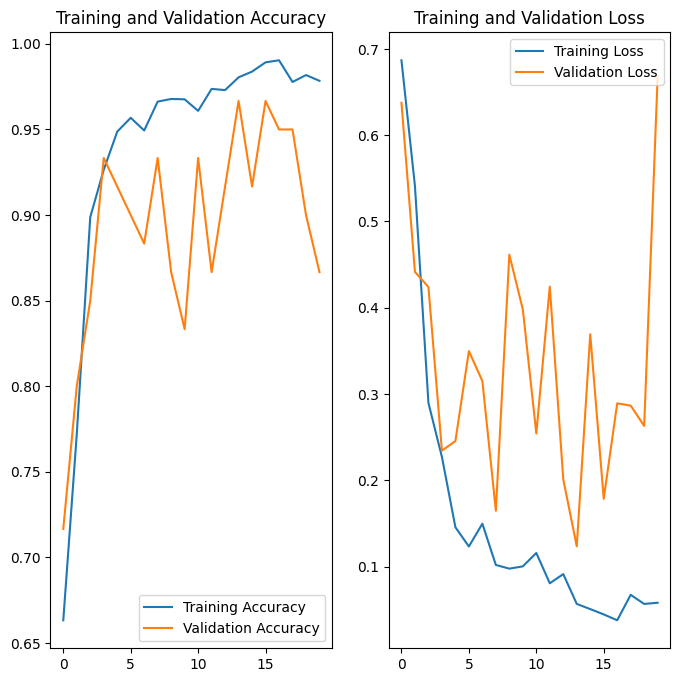

In [ ]:
EPOCHS = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Powdery
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
predicted label: Powdery


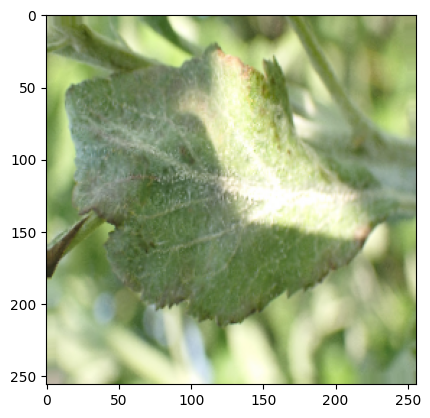

In [ ]:
import numpy as np


for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    break

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


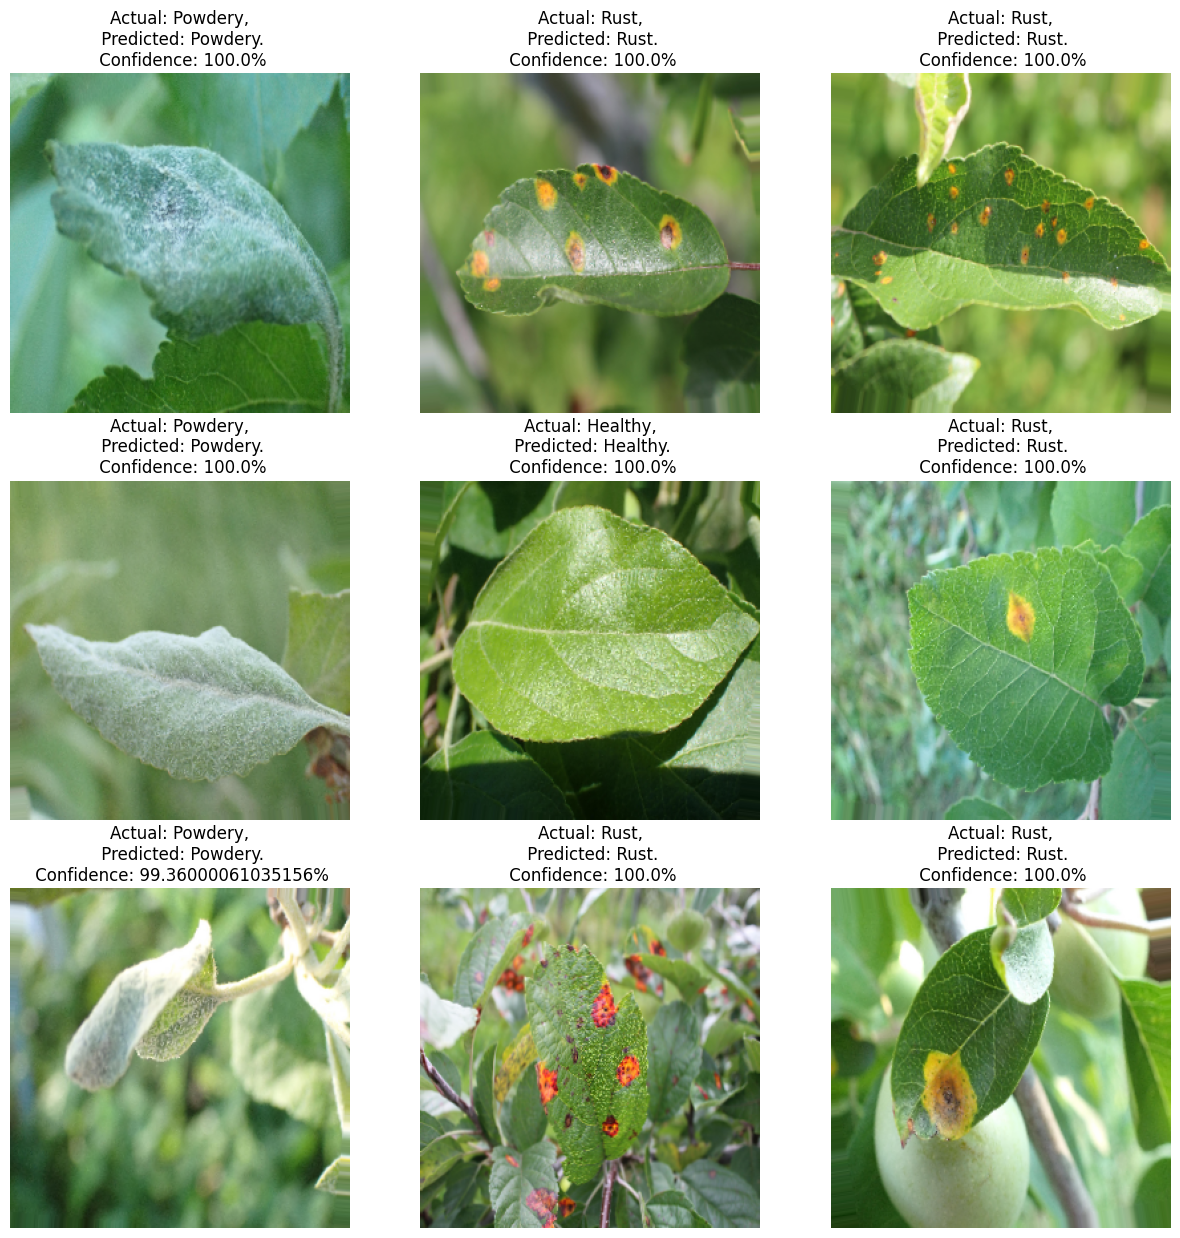

In [ ]:

plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

In [ ]:
model.save('my_model.keras')